In [175]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [199]:
def show_image(img_list):
    plt.figure(figsize=(20,20))
    # show 12 images in 3 rows and 4 columns
    for i in range(len(img_list)):
        plt.subplot(3, len(img_list) // 3, i+1)
        plt.imshow(img_list[i])
    plt.show()

# -N? Đọc ảnh

In [177]:
img = Image.open('lena.png')
img_2d = np.array(img)

In [202]:
img_list = np.array([img_2d, img_2d, img_2d,img_2d,img_2d,img_2d,img_2d,img_2d,img_2d, img_2d, img_2d, img_2d])

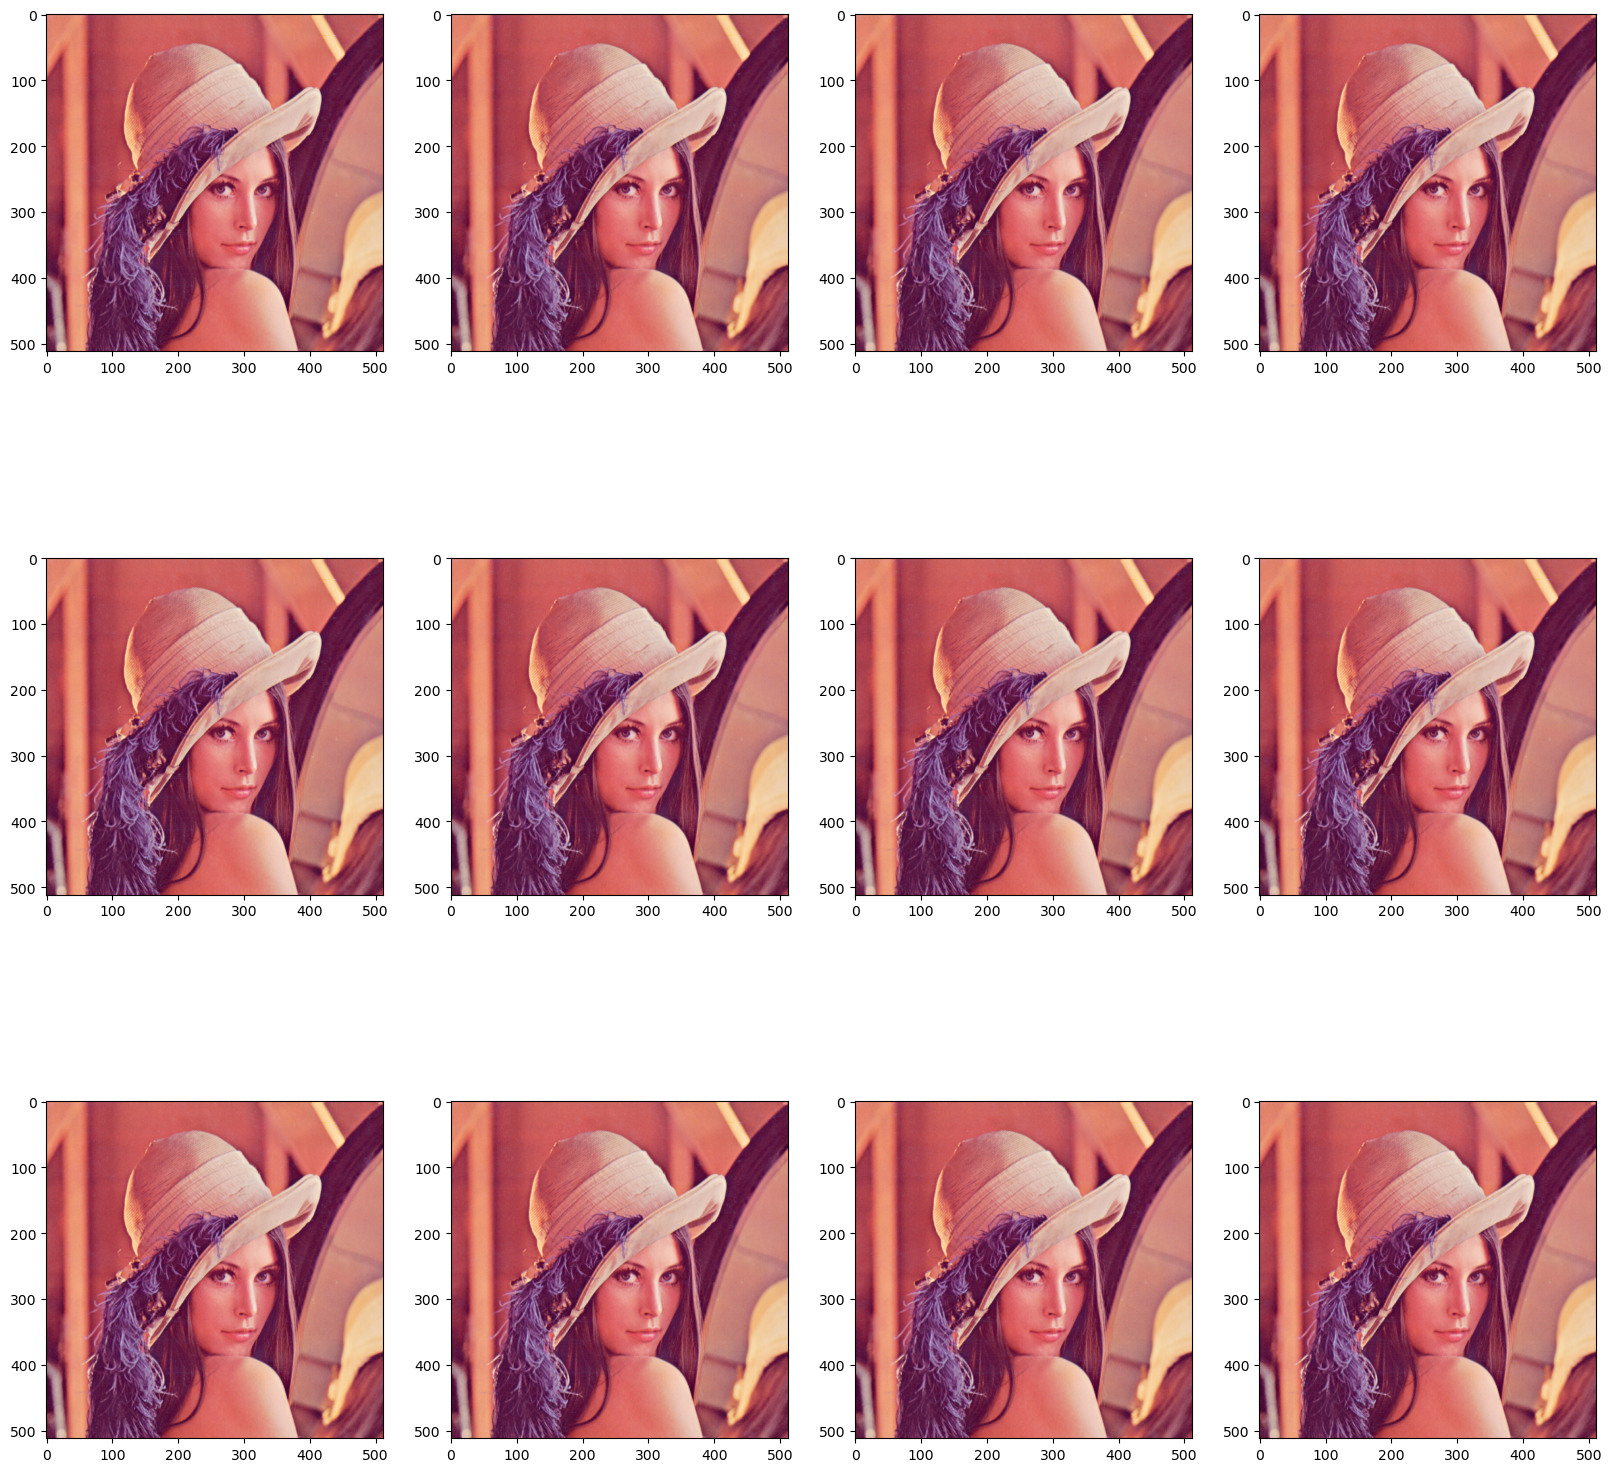

In [203]:
show_image(img_list)

# 1. Thay đổi độ sáng cho ảnh 

In [ ]:
def limit_value(img_2d):
    return np.clip(img_2d, 0, 255, out=img_2d)

In [ ]:
def change_brightness(img_2d, brightness=128):
    return limit_value(img_2d.astype('int64') + brightness).astype('uint8')

# 2. Thay đổi độ tương phản của ảnh

In [ ]:
def change_contrast(img_2d, contrast=128):
    factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
    return limit_value(factor * (img_2d.astype('float64') - 128) + 128).astype('uint8')

# 3. Lật ảnh ngang dọc

In [ ]:
def flip_image(img_2d, axis):
    return np.flip(img_2d, axis)

# 4. RGB &rarr; grayscale, RGB &rarr; sepia

In [ ]:
def convert_grayscale(img_2d):
    if (img_2d.shape[-1] == 4):
        img_2d = img_2d[..., :3]
    gray_image = np.dot(img_2d, [0.3, 0.59, 0.11]).astype('uint8')
    return np.repeat(gray_image[...,None], img_2d.shape[-1], axis=-1)

In [ ]:
def convert_sepia(img_2d):
    sepia_array = np.array([[0.393, 0.769, 0.189], [0.349, 0.686, 0.168], [0.272, 0.534, 0.131]])
    new_sepia = np.dot(img_2d, sepia_array.T)
    return limit_value(new_sepia).astype('uint8')

# 5. Làm mờ/sắc nét

In [ ]:
def convolute_2D(img_2d, kernel):
    kernel_size = kernel.shape[0]
    
    # Initialize new image
    img_size = img_2d.shape[:2]
    new_img_2d = np.zeros(img_size + (3,)).astype('float64')
    
    # padding with the edge values
    img_2d = np.pad(img_2d, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0, 0)), mode='edge')
    
    # Convolution
    for i in range(img_size[0]):
        for j in range(img_size[1]):
            for k in range(3):
                new_img_2d[i, j, k] = img_2d[i:i+kernel_size, j:j+kernel_size, k].flatten() @ kernel.flatten()
                
    return limit_value(new_img_2d).astype('uint8')

In [ ]:
def blur_image(img_2d):
    gaussian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    print(gaussian_kernel.flatten())
    return convolute_2D(img_2d, gaussian_kernel)

In [ ]:
def sharpen_image(img_2d):
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return convolute_2D(img_2d, sharpen_kernel)

# 6. Cắt ảnh

In [ ]:
def center_crop(img_2d, height=256, width=256):
    h, w = img_2d.shape[:2]
    x1 = (w - width) // 2
    y1= (h - height) // 2
    y2 = y1 + height 
    x2 = x1 + width
    return img_2d[y1:y2, x1:x2]

# 7. Cắt ảnh theo khung hình tròn

In [ ]:
def circular_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)
    radius = min(center)

    Y, X = np.ogrid[:h, :w]
    mask = (X - center[1])**2 + (Y - center[0])**2 > radius**2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask] = 0
    
    return new_img_2d

# 8. Elip mask

## Phương trình đường elip tổng quát:

- [tham khảo](https://math.stackexchange.com/questions/426150/what-is-the-general-equation-of-the-ellipse-that-is-not-in-the-origin-and-rotate)
- [tham khảo 2](https://www.maa.org/external_archive/joma/Volume8/Kalman/General.html)

$\frac{((x-x_0)\cos \alpha + (y-y_0) \sin \alpha)^2}{a^2} + \frac{((x-x_0)\sin \alpha - (y-y_0) \cos \alpha)^2}{b^2}= 1$ 

Với:
- $\alpha$ là góc quay của đường elip so với hệ tọa độ
- $x_0, y_0$ là tọa độ tâm của đường elip

Do tính đối xứng nên ta có thể suy ra $\alpha = \frac{\pi}{4} = 45^{\circ}$ hoặc $\alpha = \frac{3\pi}{4} = 135^{\circ}$.

Khi đó phương trình elip trở thành:
$(\frac{1}{a^2} + \frac{1}{b^2})((x-x_0)^2 + (y-y_0)^2) \pm 2(\frac{1}{a^2} - \frac{1}{b^2})(x-x_0) (y-y_0) = 2$

In [ ]:
def elliptical_crop(img_2d):
    h, w = img_2d.shape[:2]
    center = (h // 2, w // 2)

    # for 1x1 square
    a = 0.35
    b = -0.61375
    
    # for h x w square
    new_a = a * h
    new_b = b * w
    
    Y, X = np.ogrid[:h, :w]
    
    const_1 = 1 / new_a**2 + 1 / new_b**2
    const_2 = 1 / new_a**2 - 1 / new_b**2
    
    mask_l = const_1 * ((X - center[1])**2 + (Y - center[0])**2) - const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    mask_r = const_1 * ((X - center[1])**2 + (Y - center[0])**2) + const_2 * 2 * (X - center[1]) * (Y - center[0]) > 2
    
    new_img_2d = img_2d.copy()
    new_img_2d[mask_l & mask_r] = 0
    
    return new_img_2d
plt.imshow(elliptical_crop(img_2d))
#plt.imsave('elliptical_crop.png', elliptical_crop(img_2d))

In [ ]:
def main():
    img_name = input('Nhập đường dẫn ảnh: ')
    img_2d = np.array(Image.open(img_name))
    print("""
    0. Tất cả chức năng
    1. Đổi độ sáng (mặc định: 128)
    2. Đổi độ tương phản (mặc định: 128)
    3. Lật ảnh ngang/dọc
    4. Chuyển sang ảnh xám/sepia
    5. Làm mờ/sắc nét ảnh
    6. Cắt ảnh theo kích thước (mặc định: 256x256)
    7. Cắt ảnh theo khung tròn
    8. Cắt ảnh theo khung elip
    9. Thoát
          """)
    function = int(input('Chọn chức năng: '))
    while True:
        img_list = [img_2d]
        if function == 1:
            img_brightness = change_brightness(img_2d)
            img_list.append(img_brightness)
        elif function == 2:
            img_contrast = change_contrast(img_2d)
            img_list.append(img_contrast)
        elif function == 3:
            img_vflip = flip_image(img_2d, 0)
            img_hflip = flip_image(img_2d, 1)
            img_list.append(img_vflip)
            img_list.append(img_hflip)
        elif function == 4:
            img_grayscale = convert_grayscale(img_2d)
            img_sepia = convert_sepia(img_2d)
            img_list.append(img_grayscale)
        elif function == 5:
            img_blur = blur_image(img_2d)
            img_sharpen = sharpen_image(img_2d)
            img_list.append(img_blur)
            img_list.append(img_sharpen)
        elif function == 6:
            img_center_crop = center_crop(img_2d)
        elif function == 7:
            img_circular_crop = circular_crop(img_2d)
        elif function == 8:
            img_elliptical_crop = elliptical_crop(img_2d)
        elif function == 9:
            break
        elif function == 0:
            img_list = [img_2d, img_brightness, img_contrast, img_vflip, img_hflip, img_grayscale, img_sepia, img_blur, img_sharpen, img_center_crop, img_circular_crop, img_elliptical_crop]
            

In [ ]:
if __name__ == '__main__':
    main()